In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
sys.path.insert(0, '..//')

import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

from src.models import thermal_model
from src.common import functions, enums, schema
from src.data import source


In [26]:
# Parameters 
path_results:Path = Path().absolute().parent/"data"
target_area:enums.Area = enums.Area.CARDIFF
target_year:int = 2020
CDD_ref_temperature:float = 24
solar_gains = True
timestep:int = 3600

# Dwelling parameters
R_dwelling = 1/0.2 #K/kW
C_dwelling = 20_000 #kJ/K
floor_area = 50 #m2
initial_indoor_air_temperature = 21

In [27]:
# Load outdoor air temperature data for Cardiff
input_data = pd.read_csv(path_results/"raw"/f"{target_area.value}_degree_days.csv", index_col=0, parse_dates=True)

# Create models
dwelling = thermal_model.ThermalModel(R=R_dwelling, C=C_dwelling, initial_indoor_air_temperature=initial_indoor_air_temperature)
data_source = source.SimulationData(dwelling, input_data, timestep_simulation=3600)

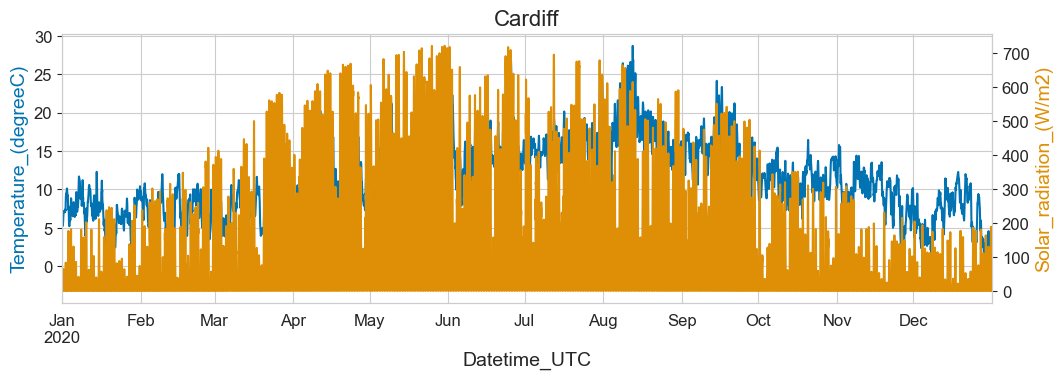

In [28]:
fig, ax = plt.subplots(figsize=figsize)
dataf = data_source.filter_era5_data(list_years=[target_year])
ax2 = ax.twinx()
dataf[schema.OutputDataSchema.SOLARRADIATION].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.OutputDataSchema.SOLARRADIATION, color=sns.color_palette()[1])
dataf[schema.OutputDataSchema.OAT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.OutputDataSchema.OAT, color=sns.color_palette()[0])

ax2.grid(False)
ax.set_title(f"{target_area.value}")
ax.legend().remove()
ax.margins(0, None)

Text(0, 0.5, 'Heating_season_flag')

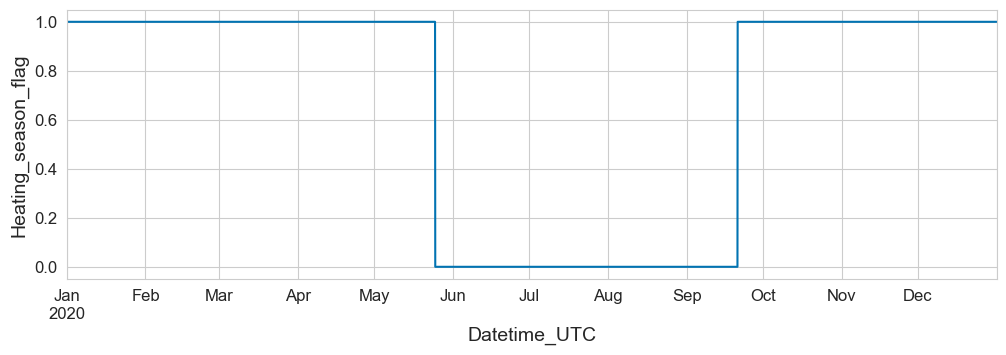

In [29]:
fig, ax = plt.subplots(figsize=figsize)
dataf[schema.OutputDataSchema.HEATINGSEASON].plot(ax=ax)
ax.set_ylabel(schema.OutputDataSchema.HEATINGSEASON)

In [30]:
rcmodel_dataf=data_source.create_era5_based_simulation_data(estimate_solar_gains=solar_gains, list_years=[target_year])
rcmodel_dataf = dwelling.estimate_heating_demand(rcmodel_dataf)
resampled_rcmodel_dataf = data_source.resample_modelling_results(rcmodel_dataf)
functions.print_heating_and_cooling_demand(resampled_rcmodel_dataf)

heating demand 12165.234822164792kWh and cooling demand is -573.7063916947673kWh


(12165.234822164792, -573.7063916947673)

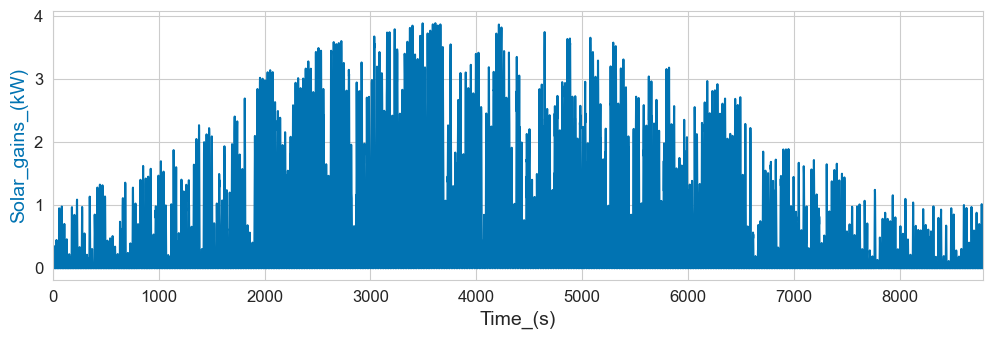

In [31]:
fig, ax = plt.subplots(figsize=figsize)
resampled_rcmodel_dataf[schema.DataSchema.SOLARGAINS].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.DataSchema.SOLARGAINS, color=sns.color_palette()[0])
ax.margins(0, None)

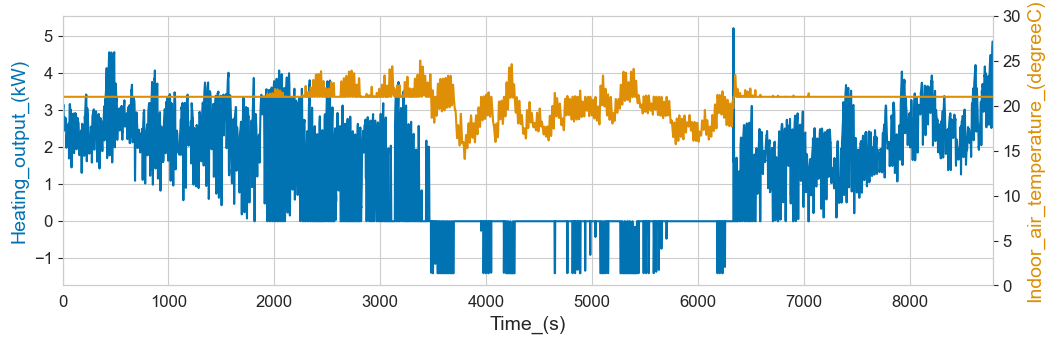

In [32]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
resampled_rcmodel_dataf[schema.DataSchema.HEATINGOUTPUT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.DataSchema.HEATINGOUTPUT, color=sns.color_palette()[0])
resampled_rcmodel_dataf[schema.DataSchema.IAT].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.DataSchema.IAT, color=sns.color_palette()[1])
ax2.set_ylim(0, 30)
ax2.grid(False)
ax.margins(0, None)

In [33]:
resampled_rcmodel_dataf.index= dataf.index
resampled_rcmodel_dataf.to_csv(r"../data/demo_dwelling_results/simulation_results.csv")

In [18]:

functions.add_time_features(resampled_rcmodel_dataf)

resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON] = dataf[schema.OutputDataSchema.HEATINGSEASON] 
resampled_rcmodel_dataf[schema.OutputDataSchema.SOLARRADIATION] = dataf[schema.OutputDataSchema.SOLARRADIATION] 

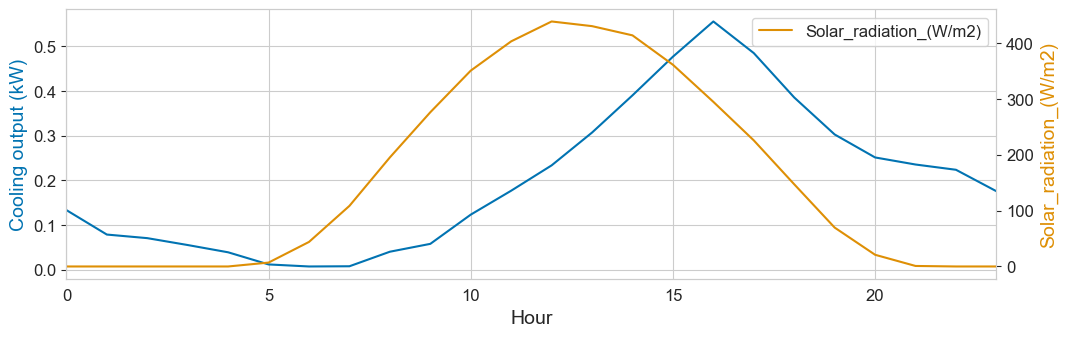

In [19]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
filt = (resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON]==0)

(resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.OutputDataSchema.SOLARRADIATION:"mean"})).plot(ax=ax2, color=sns.color_palette()[1])
(-resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.HEATINGOUTPUT:"mean"})).plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel("Cooling output (kW)", color=sns.color_palette()[0])
ax.legend().remove()
ax2.set_ylabel(schema.OutputDataSchema.SOLARRADIATION, color=sns.color_palette()[1])
ax2.grid(False)
ax.margins(0, None)

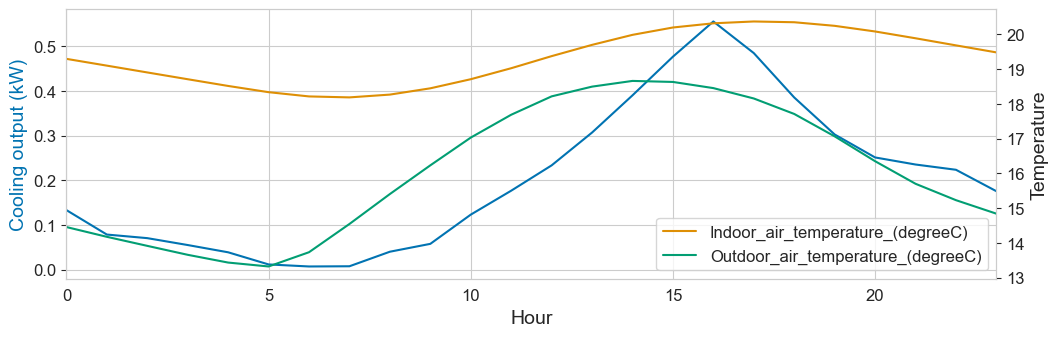

In [20]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
filt = (resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON]==0)

resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.IAT:"mean"}).plot(ax=ax2, color=sns.color_palette()[1])
resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.OAT:"mean"}).plot(ax=ax2, color=sns.color_palette()[2])
(-resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.HEATINGOUTPUT:"mean"})).plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel("Cooling output (kW)", color=sns.color_palette()[0])
ax.legend().remove()
ax2.set_ylabel("Temperature")
ax2.grid(False)
ax.margins(0, None)



In [21]:
resampled_rcmodel_dataf

,Indoor_air_temperature_(degreeC),Outdoor_air_temperature_(degreeC),Heating_output_(kW),Solar_radiation(W/m2),Solar_gains_(kW),Heating_season_flag,Hour,Day_of_week,Day,Month,Year,Weekday_flag,HH,Date,Week,Solar_radiation_(W/m2)
Datetime_UTC,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,21.0,6.219452,0.000000,0.0,0.0,1,0,2,1,1,2020,1,0,2020-01-01,1,0.0
2020-01-01 01:00:00+00:00,21.0,6.148834,2.970233,0.0,0.0,1,1,2,1,1,2020,1,2,2020-01-01,1,0.0
2020-01-01 02:00:00+00:00,21.0,5.984192,3.003162,0.0,0.0,1,2,2,1,1,2020,1,4,2020-01-01,1,0.0
2020-01-01 03:00:00+00:00,21.0,5.947174,3.010565,0.0,0.0,1,3,2,1,1,2020,1,6,2020-01-01,1,0.0
2020-01-01 04:00:00+00:00,21.0,5.870697,3.025861,0.0,0.0,1,4,2,1,1,2020,1,8,2020-01-01,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,21.0,-1.605987,4.521198,0.0,0.0,1,19,3,366,12,2020,1,38,2020-12-31,53,0.0
2020-12-31 20:00:00+00:00,21.0,-2.474487,4.694897,0.0,0.0,1,20,3,366,12,2020,1,40,2020-12-31,53,0.0
2020-12-31 21:00:00+00:00,21.0,-2.885620,4.777124,0.0,0.0,1,21,3,366,12,2020,1,42,2020-12-31,53,0.0


In [22]:
dataf

,Solar_radiation_(W/m2),Temperature_(degreeC),hdd_15.5,cdd_24.0,Heating_season_flag
Datetime_UTC,,,,,
2020-01-01 00:00:00+00:00,0.0,6.219452,0.386690,0.0,1
2020-01-01 01:00:00+00:00,0.0,6.148834,0.389632,0.0,1
2020-01-01 02:00:00+00:00,0.0,5.984192,0.396492,0.0,1
2020-01-01 03:00:00+00:00,0.0,5.947174,0.398034,0.0,1
2020-01-01 04:00:00+00:00,0.0,5.870697,0.401221,0.0,1
...,...,...,...,...,...
2020-12-31 19:00:00+00:00,0.0,-1.605987,0.712749,0.0,1
2020-12-31 20:00:00+00:00,0.0,-2.474487,0.748937,0.0,1
2020-12-31 21:00:00+00:00,0.0,-2.885620,0.766068,0.0,1


In [ ]:
results_dict = {}
heating_demand_dict = {}
for year in data_source.all_years[5:]:
    print(year)
    rcmodel_dataf=data_source.create_era5_based_simulation_data(estimate_solar_gains=solar_gains,list_years=[year])
    rcmodel_dataf = dwelling.estimate_heating_demand(rcmodel_dataf)
    resampled_rcmodel_dataf = data_source.resample_modelling_results(rcmodel_dataf)
    heating_demand, cooling_demand = functions.print_heating_and_cooling_demand(resampled_rcmodel_dataf)
    results_dict[year] = (heating_demand, cooling_demand)
    heating_demand_dict[year] = resampled_rcmodel_dataf.loc[:5088, schema.DataSchema.HEATINGOUTPUT].values
results_df = pd.DataFrame(results_dict, index=[schema.ResultSchema.HEATINGDEMAND, schema.ResultSchema.COOLINGDEMAND])
results_df.columns.names = [schema.ResultSchema.YEAR]

2015
heating demand 12327.005806246847kWh and cooling demand is -188.59824355224714kWh
2016
heating demand 13292.141289084695kWh and cooling demand is -415.0755224846754kWh
2017
heating demand 12427.135776742765kWh and cooling demand is -382.19344240012714kWh
2018
heating demand 13165.13755407479kWh and cooling demand is -888.4241567814822kWh
2019
heating demand 12753.718762475108kWh and cooling demand is -534.7900696472108kWh
2020
heating demand 12165.234822164792kWh and cooling demand is -573.7063916947673kWh
2021
heating demand 12958.890511455804kWh and cooling demand is -474.7069313799368kWh
2022
heating demand 7151.259175947033kWh and cooling demand is -454.7033024720937kWh


In [11]:
profiles_df = pd.DataFrame.from_dict(heating_demand_dict)


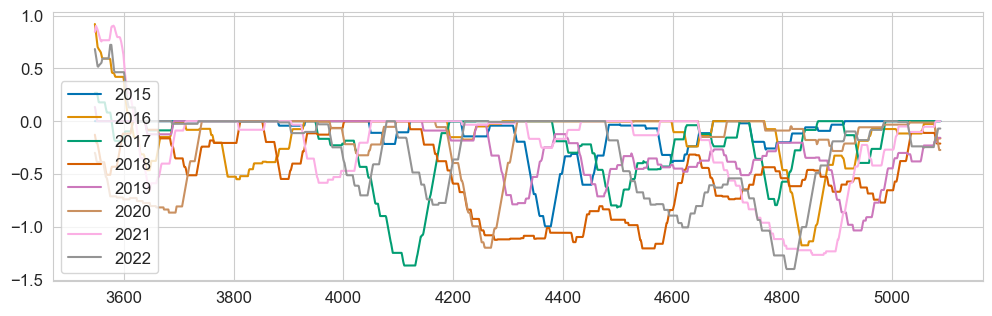

In [12]:
fig, ax = plt.subplots(figsize=figsize)
for c in profiles_df.columns:

    profiles_df.loc[3500:, c].rolling(window=48).mean().plot(ax=ax)

ax.legend()

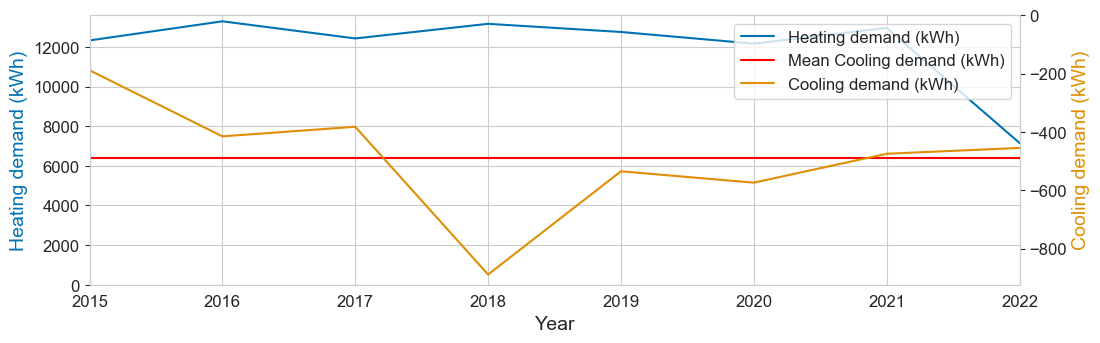

In [13]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
results_df.T[schema.ResultSchema.HEATINGDEMAND].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.ResultSchema.HEATINGDEMAND, color=sns.color_palette()[0])


x_arr = results_df.columns
y_mean = [results_df.T[schema.ResultSchema.COOLINGDEMAND].mean()]*len(x_arr)
ax2.plot(x_arr, y_mean, label=f"Mean {schema.ResultSchema.COOLINGDEMAND}", color='red')
results_df.T[schema.ResultSchema.COOLINGDEMAND].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.ResultSchema.COOLINGDEMAND, color=sns.color_palette()[1])
ax2.set_ylim(None, 0)
ax.set_ylim(0, None)
ax2.grid(False)
ax.margins(0, None)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)